# Détection des faux Billets

Votre société de consulting informatique vous propose une nouvelle mission : créer un algorithme de détection de faux billets.

Le [jeu de données](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-analyst/notes.csv)  contenant les caractéristiques géométriques de billets de banque. Pour chacun d'eux, nous connaissons :

 - la longueur du billet (en mm) ;  
 - la hauteur du billet (mesurée sur le côté gauche, en mm) ;  
 - La hauteur du billet (mesurée sur le côté droit, en mm) ;  
 - la marge entre le bord supérieur du billet et l'image de celui-ci (en mm) ;  
 - la marge entre le bord inférieur du billet et l'image de celui-ci (en mm) ;  
 - la diagonale du billet (en mm).

L'étude va consister en 3 parties : 

Partie 1 : analyse exploratoire univariée et bivariée de votre jeu de données  
Partie 2 : ACP 
    Vous réaliserez une analyse en composantes principales de l'échantillon, en suivant toutes ces étapes :  

analyse de l'éboulis des valeurs propres ;
représentation des variables par le cercle des corrélations ;
représentation des individus par les plans factoriels ;
analyser de la qualité de représentation et la contribution des individus.
Pour chacune de ces étapes, commentez les résultats obtenus. La variable donnant la nature Vrai/Faux du billet sera utilisée comme variable illustrative.

Si besoin de compléments sur l'ACP, n'hésitez pas à vous référez à [cours](https://openclassrooms.com/fr/courses/4525281-realisez-une-analyse-exploratoire-de-donnees/5280368-comprenez-lenjeu-de-lanalyse-en-composantes-principales) si besoin pour la partie plus théorique

Partie 3 : Réaliser une classification des billets (révisions de kmeans ou régression logique, et aller creuser côté CAH)

In [1]:
# Import des librairies
import numpy as np
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import sklearn
#classe pour l'ACP
from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics


from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.hierarchy import dendrogram
import scipy.stats as scs
from scipy.stats import ks_2samp

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools import add_constant
from statsmodels.api import Logit

from math import pi

## Partie 0 : ANALYSES BIVARIES

Dans cette partie, vous allez explorer vos données via des visualisations, par exemple :   
    
    - le nombre de billets vrai/faux  
    - les distributions de longueurs, largeurs and co des billets de votre dataset
    - longueur/largeur and co des billets vrais vs. faux
    - etc -> be creative :)

In [3]:
df=pd.read_csv('./notes.csv')
df

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55
...,...,...,...,...,...,...,...
165,False,172.11,104.23,104.45,5.24,3.58,111.78
166,False,173.01,104.59,104.31,5.04,3.05,110.91
167,False,172.47,104.27,104.10,4.88,3.33,110.68
168,False,171.82,103.97,103.88,4.73,3.55,111.87


Text(0.5, 1.0, 'Proportion de faux billets')

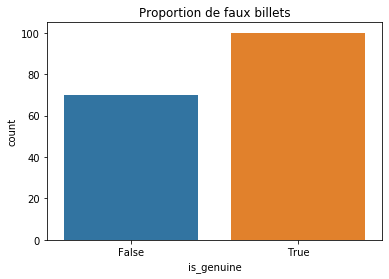

In [5]:
sns.countplot(df.is_genuine)
plt.title("Proportion de faux billets")

Index(['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up',
       'length'],
      dtype='object')

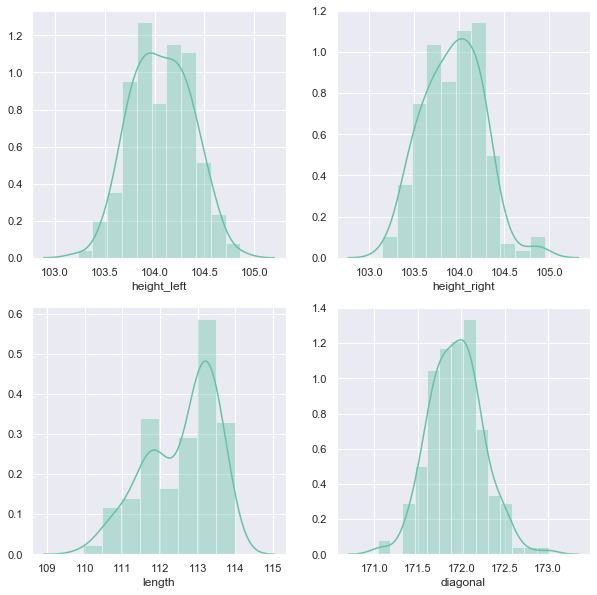

In [88]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
sns.distplot(df.height_left)
plt.subplot(2,2,2)
sns.distplot(df.height_right)
plt.subplot(2,2,3)
sns.distplot(df.length)
plt.subplot(2,2,4)
sns.distplot(df.diagonal)

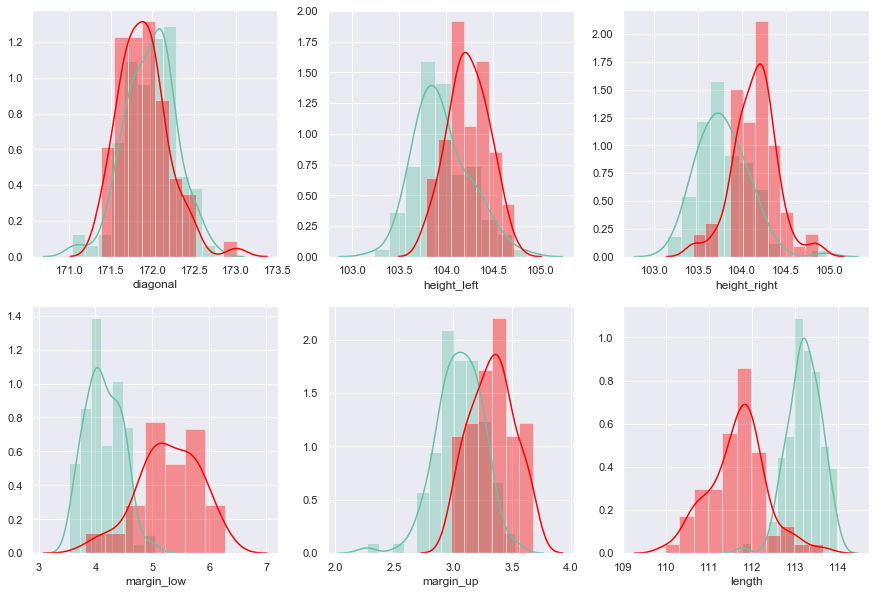

In [87]:
listeC=df.iloc[:,1:].columns
n=1
plt.figure(figsize=(15,10))
for i in listeC:
    plt.subplot(2,3,n)
    sns.distplot(df[i].loc[df["is_genuine"] == True])
    sns.distplot(df[i].loc[df["is_genuine"] == False], color= "red")
    n=n+1

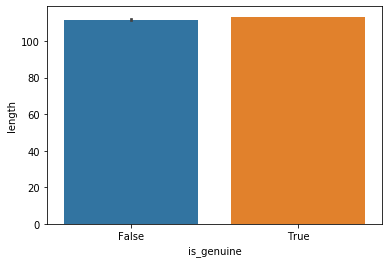

In [18]:
sns.barplot(df.is_genuine, df.length)

In [22]:
dfmoyenne= df.groupby(by="is_genuine").mean()
dfmoyenne

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
False,171.889857,104.230429,104.145571,5.281571,3.334571,111.660714
True,171.976100,103.951500,103.775900,4.143500,3.055500,113.207200


In [55]:
Fmoy=dfmoyenne.iloc[0,:].values
Tmoy=dfmoyenne.iloc[1,:].values
listeN=dfmoyenne.columns
listeN

Index(['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up',
       'length'],
      dtype='object')

([<matplotlib.patches.Wedge at 0x1764e94f088>,
 [Text(0.3010292715984893, 1.058008212463818, ''),
  Text(-0.30102917254061, -1.0580082406482079, '')])

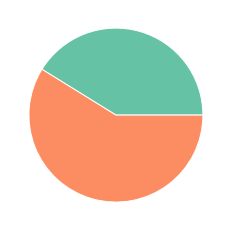

In [147]:
plt.pie(df.is_genuine.groupby(df["is_genuine"]).count())

Text(0.5, 1.0, 'Statistiques des faux billets')

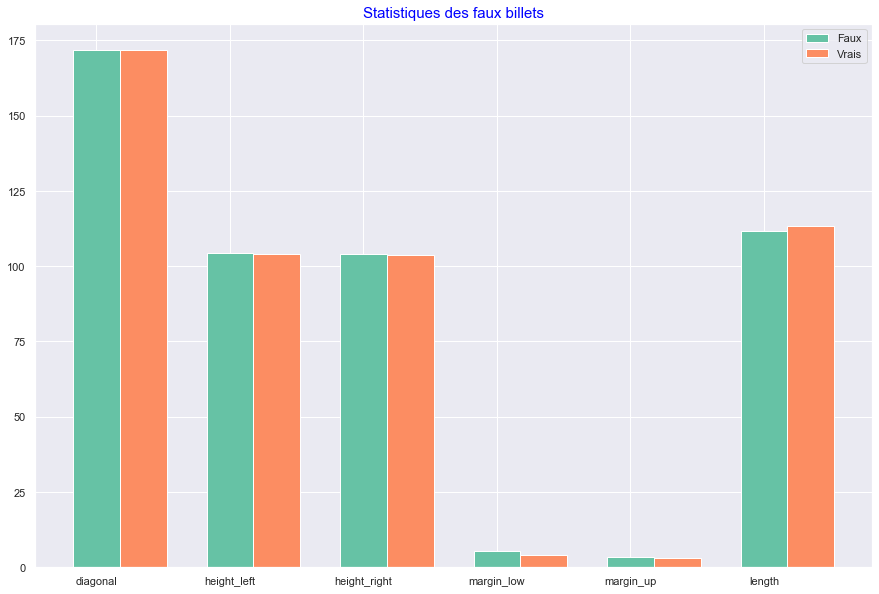

In [62]:
N= 5 #Nombre de catégorie
ind= [0,1,2,3,4,5]
ind2=[0.35,1.35,2.35,3.35,4.35,5.35]
width= 0.35
sns.set(palette='Set2')
plt.figure(figsize=[15,10])
p1= plt.bar(ind, Fmoy, width)
p2=plt.bar(ind2,Tmoy, width,)
plt.xticks(ind,listeN)
plt.legend((p1[0], p2[0]), ('Faux', 'Vrais'))
plt.title('Statistiques des faux billets', fontsize=15, color="blue")

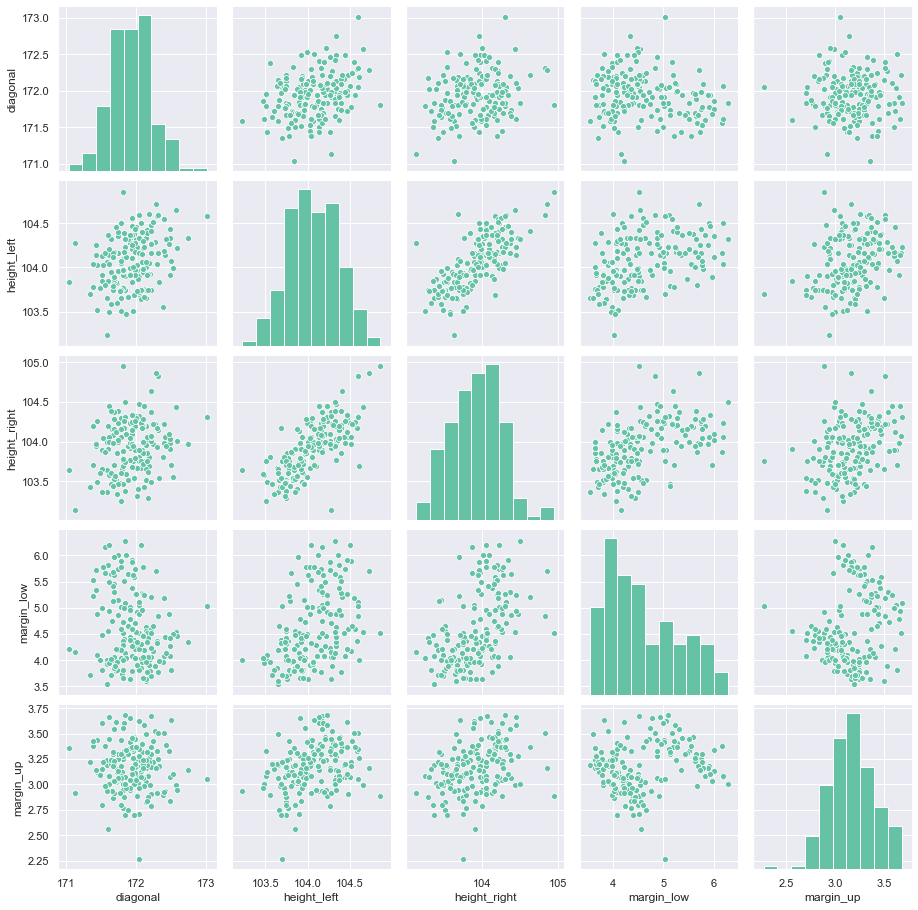

In [74]:
sns.pairplot(df.iloc[:,1:6])

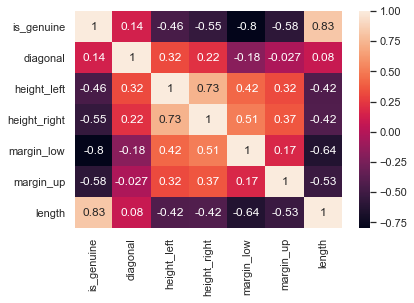

In [75]:
sns.heatmap(df.corr(),annot=True)

## Partie 1 : ANALYSE EN COMPOSANTES PRINCIPALES

Repartez de l'exploration via l'étude VISA pour cette partie + le cours sur OC
Dans tous les cas, je veux voir : 
    - un diagramme ebouli pour expliquer le pourcentage d'inertie de vos composantes principales
    - un cercle des corrélations de vos variables + l'interprétation de celui-ci
    - représentaiton des individus (= des billets) sur le plan factoriel

### Avec ou sans scale ? 

### sans

In [104]:
from sklearn.preprocessing import scale
pca = PCA()
# Sélection des variables quantitatives
dat=df.iloc[:,1:6]
# réduction
# composantes principales
C1 = pca.fit(dat).transform(dat)

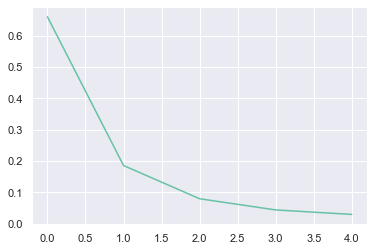

In [105]:
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.show()

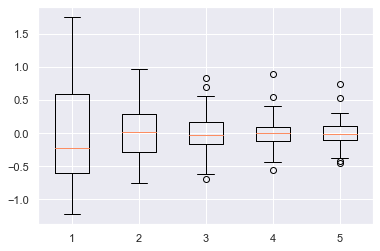

In [107]:
#Diagramme en boite représence nos composantes principales. 
plt.figure()
plt.boxplot(C1[:,0:6])
plt.show()

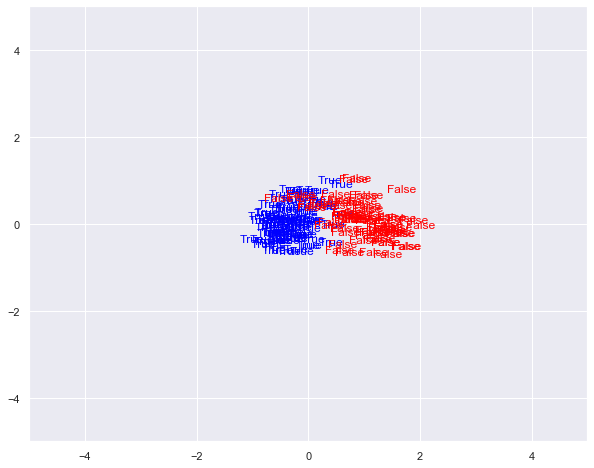

In [146]:
plt.figure(figsize=(10,8))
for i, j, nom in zip(C1[:,0], C1[:,1], df['is_genuine']):
    color = "red" if nom == False else "blue"
    plt.text(i, j, nom, color=color)
    plt.axis((-5,5,-5,5))
plt.show()

### Avec

In [110]:
from sklearn.preprocessing import scale
pca = PCA()
# Sélection des variables quantitatives
dat=df.iloc[:,1:6]
# réduction
data = pd.DataFrame(scale(dat),columns=dat.columns)
# composantes principales
C = pca.fit(data).transform(data)

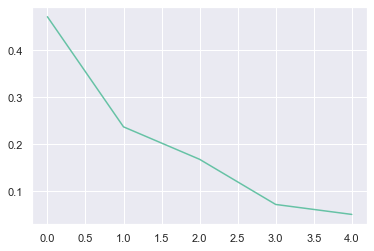

In [111]:
#Diagramme d'éboulis qui permet de visualiser nos dimensions. 
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.show()


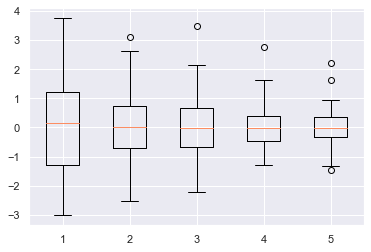

In [112]:
#Diagramme en boite représence nos composantes principales. 
plt.figure()
plt.boxplot(C[:,0:6])
plt.show()

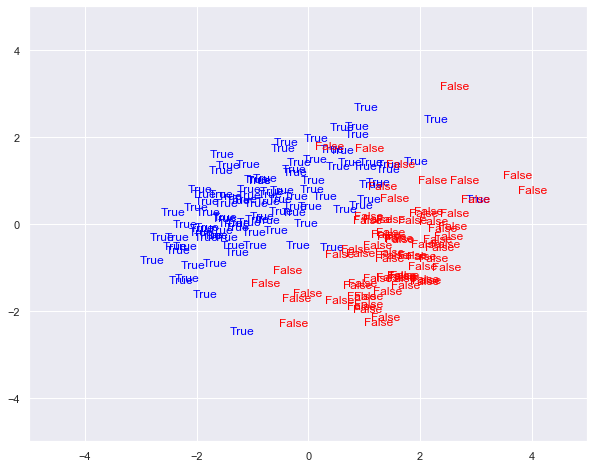

In [145]:
plt.figure(figsize=(10,8))
for i, j, nom in zip(C[:,0], C[:,1], df['is_genuine']):
    color = "red" if nom == False else "blue"
    plt.text(i, j, nom, color=color)
    plt.axis((-5,5,-5,5))
plt.show()

### Avec log et Scale

In [135]:
def log1(x):
    return np.log(1+x)
dftrans=df
dftrans.iloc[:,1:]=log1(dftrans.iloc[:,1:])
dftrans

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,0.710793,0.695989,0.696016,0.525510,0.482114,0.698304
1,True,0.710770,0.695646,0.695634,0.514555,0.481386,0.698431
2,True,0.710796,0.695652,0.695652,0.523088,0.481751,0.698583
3,True,0.710791,0.695658,0.695618,0.507701,0.490029,0.698525
4,True,0.710832,0.695634,0.695649,0.535070,0.455820,0.698503
...,...,...,...,...,...,...,...
165,False,0.710842,0.695797,0.695864,0.538395,0.503735,0.698011
166,False,0.710989,0.695907,0.695821,0.535070,0.487704,0.697766
167,False,0.710901,0.695809,0.695757,0.532277,0.496602,0.697700
168,False,0.710794,0.695717,0.695689,0.529543,0.502915,0.698036


In [151]:
from sklearn.preprocessing import scale
pca = PCA()
# Sélection des variables quantitatives
dat=dftrans.iloc[:,1:]
# réduction
data = pd.DataFrame(scale(dat),columns=dat.columns)
# composantes principales
C2 = pca.fit(data).transform(data)

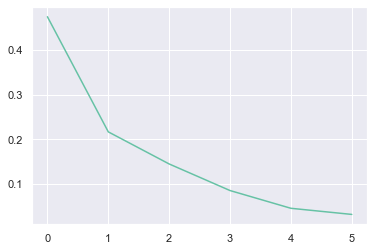

In [152]:
#Diagramme d'éboulis qui permet de visualiser nos dimensions. 
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.show()

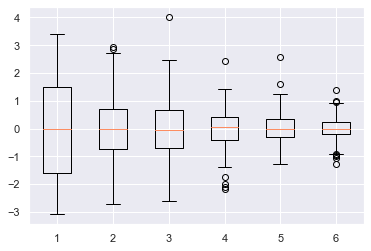

In [153]:
#Diagramme en boite représence nos composantes principales. 
plt.figure()
plt.boxplot(C2[:,0:6])
plt.show()

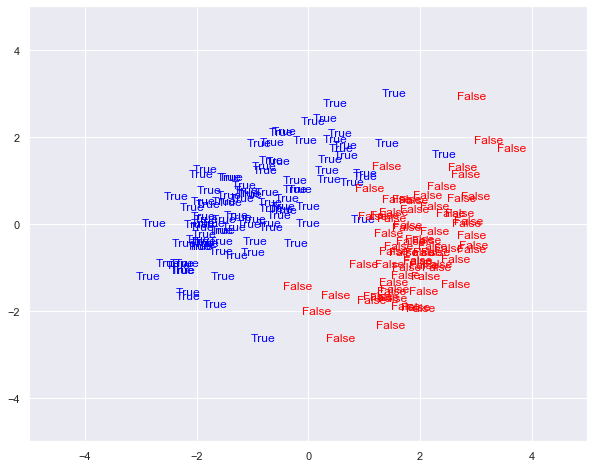

In [154]:
plt.figure(figsize=(10,8))
for i, j, nom in zip(C2[:,0], C2[:,1], dftrans['is_genuine']):
    color = "red" if nom == False else "blue"
    plt.text(i, j, nom, color=color)
plt.axis((-5,5,-5,5))
plt.show()

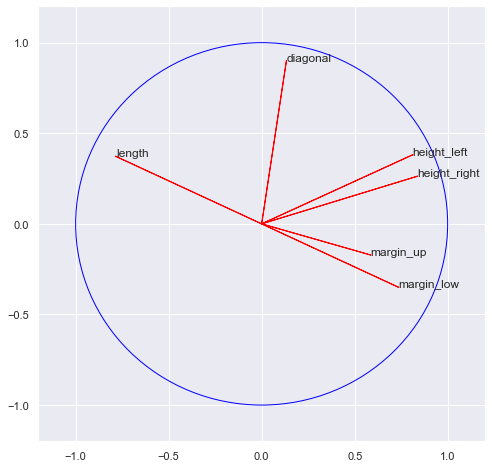

In [155]:
# coordonnées des variables
coord1=pca.components_[0]*np.sqrt(pca.explained_variance_[0])
coord2=pca.components_[1]*np.sqrt(pca.explained_variance_[1])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
for i, j, nom in zip(coord1,coord2, data.columns):
    plt.text(i, j, nom)
    plt.arrow(0,0,i,j,color='r')
plt.axis((-1.2,1.2,-1.2,1.2))
# cercle
c=plt.Circle((0,0), radius=1, color='b', fill=False)
ax.add_patch(c)
plt.show()

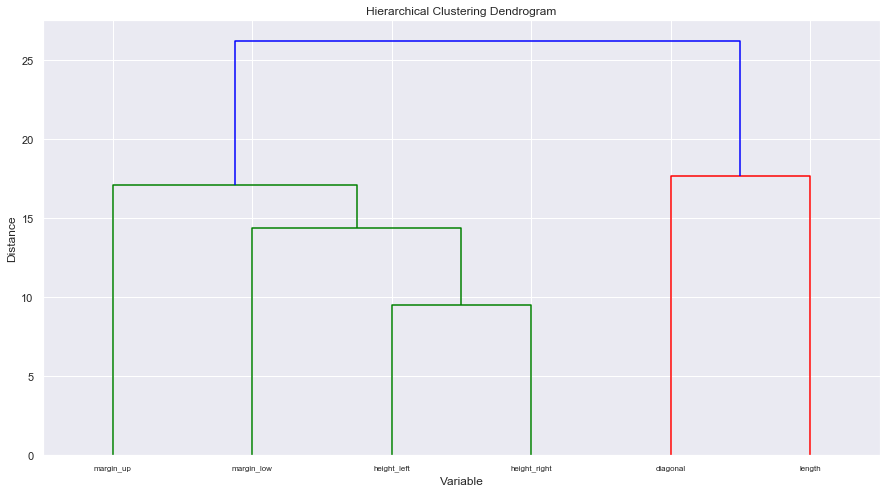

In [156]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(data.T, 'ward')
plt.figure(figsize=(15, 8))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Variable')
plt.ylabel('Distance')
dendrogram(Z,leaf_font_size=8.,labels=data.columns)
plt.show()

## Partie 2 : PREDICTION

Effectuer la prédiction de nouveaux billets via un algorithme que vous allez mettre en place (kmeans? regression logistique? A vous de voir).  
Si besoin, je vous fournirai un nouveau jeu de données de billets afin que vous prédisiez s'ils sont vrais ou faux et qu'on valide ensuite !

In [204]:
lr=LogisticRegression()
dftrans["pca1"]=C2[:,0]
dftrans['pca2']=C2[:,1]
dftrans['pca3']=C2[:,2]
dftrans


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,pca1,pca2,pca3
0,1.0,0.710793,0.695989,0.696016,0.525510,0.482114,0.698304,2.204398,1.535585,1.739793
1,1.0,0.710770,0.695646,0.695634,0.514555,0.481386,0.698431,-2.117012,-0.508825,0.557479
2,1.0,0.710796,0.695652,0.695652,0.523088,0.481751,0.698583,-1.926067,-0.047012,0.914576
3,1.0,0.710791,0.695658,0.695618,0.507701,0.490029,0.698525,-2.103672,-0.052744,-0.638395
4,1.0,0.710832,0.695634,0.695649,0.535070,0.455820,0.698503,-2.598485,0.567059,4.026114
...,...,...,...,...,...,...,...,...,...,...
165,0.0,0.710842,0.695797,0.695864,0.538395,0.503735,0.698011,2.450334,0.174013,-0.696314
166,0.0,0.710989,0.695907,0.695821,0.535070,0.487704,0.697766,2.665161,2.863210,0.565679
167,0.0,0.710901,0.695809,0.695757,0.532277,0.496602,0.697700,2.122373,0.789450,-0.566150
168,0.0,0.710794,0.695717,0.695689,0.529543,0.502915,0.698036,0.730850,-1.004064,-1.203363


In [205]:
dftrans["is_genuine"]=dftrans["is_genuine"].replace(True,1)
dftrans["is_genuine"]=dftrans['is_genuine'].replace(False,0)

In [206]:
from sklearn.model_selection import train_test_split

data_Tr, data_Te, target_Tr, target_Te = train_test_split(dftrans.iloc[:,7:9], df.is_genuine
                                 , random_state=0
                                 , train_size=0.75)


In [207]:
lr.fit(data_Tr,target_Tr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [208]:
result=lr.predict(data_Te)

In [209]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [210]:
#On calcul la précision(Accuracy ) avec un score en %
accuracy=accuracy_score(result, target_Te)
recall= recall_score(result, target_Te, average=None)
precision= precision_score(result, target_Te, average=None)
F1= f1_score(result, target_Te, average=None)
#100 % avec 80 / 20 j'ai testé 50 / 50 pour tester j'obtiens 0.93

print("R =", recall) # précision de prédiction des valeur Positive correctement prédit
#par rapport à l'ensemble des vrais valeurs
print("A =", accuracy) # Précision sur l'ensemble des bon résultat (True positive and True neg) par rapport
#A l'ensmble des valeurs.
print("P =", precision)# Précision de prédiction des valeurs Positive par rapport à tout les donnée prédite 
#postif. 
print('F1 =', F1) #Valeur qui fait la balance entre recall et precision pour avoir une valeur qui maximise les 
#deux valeurs

R = [1.         0.96153846]
A = 0.9767441860465116
P = [0.94444444 1.        ]
F1 = [0.97142857 0.98039216]


In [201]:
conf= confusion_matrix(target_Te, result)
conf

array([[16,  2],
       [ 1, 24]], dtype=int64)

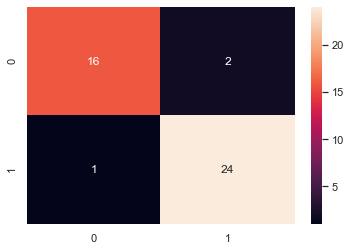

In [202]:
sns.heatmap(conf, annot=True)

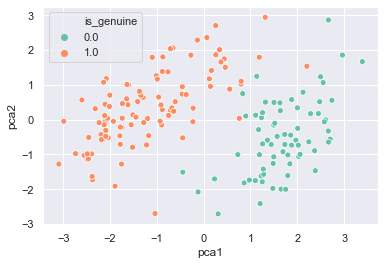

In [214]:
sns.scatterplot(dftrans.pca1, dftrans.pca2, hue=dftrans.iloc[:,0])

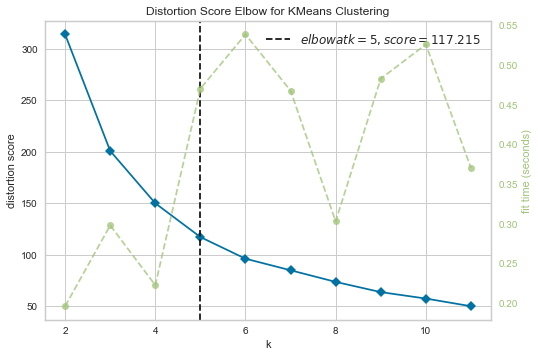

In [216]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(dftrans.iloc[:,7:9])
visualizer.show()